In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import resample
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

df_cleaned = pd.read_csv("./df_cleaned.csv")
tgt='SalePrice'
X=df_cleaned.drop(columns=[tgt])
y=df_cleaned[tgt]


In [22]:
def adjusted_r2(model, X, y):
    n = len(y)
    p = X.shape[1]
    r2 = model.score(X, y)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

## Linear Regression Model (Lasso)

In [26]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
best_alpha = 568.9866029018293

final_lasso = Lasso(alpha=best_alpha, max_iter=5000)
final_lasso.fit(X_train_scaled, y_train)

y_pred_final_lasso = final_lasso.predict(X_test_scaled)

mse_lasso_filtered = mean_squared_error(y_test, y_pred_final_lasso)
r2_lasso_filtered = r2_score(y_test, y_pred_final_lasso)
adjusted_r2_lasso_filtered = adjusted_r2(final_lasso, X_test_scaled, y_test)
cv_lasso_filtered = cross_val_score(final_lasso, X, y, cv=5, scoring='neg_mean_squared_error').mean()

MSE 339545912.8829835
R2 0.9153803807771681
Adjusted R2 2.396223717176726
CV -514251927.47188157


## Random Forest Model:

In [30]:
best_params = {
    'n_estimators': 1000,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 0.5,
    'max_depth': 25
}
final_RF_model = RandomForestRegressor(**best_params)
final_RF_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=25, max_features=0.5, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=1000)

## XGBoost Random Forest Models

In [29]:
best_params = {
    'colsample_bytree': 0.6, 
    'learning_rate': 0.01, 
    'max_depth': 3, 
    'min_child_weight': 5, 
    'n_estimators': 1300, 
    'reg_alpha': 1.5, 
    'reg_lambda': 2, 
    'subsample': 0.7
}

final_XGB_model = XGBRegressor(**best_params)
final_XGB_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define function for adjusted R²
def adjusted_r2(model, X, y):
    n = len(y)
    p = X.shape[1]
    r2 = model.score(X, y)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Datasets to evaluate on (scaled versions, as all models were trained on scaled data)
datasets = {
    "Training": (X_train_scaled, y_train),
    "Testing": (X_test_scaled, y_test)
}

# Function to evaluate model performance
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    mae = mean_absolute_error(y, predictions)
    adj_r2 = adjusted_r2(model, X, y)
    return mse, r2, mae, adj_r2

# Evaluate each model on each dataset
results = {}
for model_name, model in [("Lasso", final_lasso), ("Random Forest", final_RF_model), ("XGBoost", final_XGB_model)]:
    results[model_name] = {}
    for dataset_name, (X, y) in datasets.items():
        mse, r2, mae, adj_r2 = evaluate_model(model, X, y)
        results[model_name][dataset_name] = {
            "MSE": mse,
            "R²": r2,
            "MAE": mae,
            "Adjusted R²": adj_r2
        }

# Display results
for model_name, dataset_results in results.items():
    print(f"\n{model_name} Model Performance:")
    for dataset_name, metrics in dataset_results.items():
        print(f"  {dataset_name} Set - MSE: {metrics['MSE']:.4f}, R²: {metrics['R²']:.4f}, MAE: {metrics['MAE']:.4f}, Adjusted R²: {metrics['Adjusted R²']:.4f}")


Lasso Model Performance:
  Training Set - MSE: 295847386.5459, R²: 0.9415, MAE: 11691.6701, Adjusted R²: 0.9205
  Testing Set - MSE: 339545912.8830, R²: 0.9154, MAE: 13339.2184, Adjusted R²: 2.3962

Random Forest Model Performance:
  Training Set - MSE: 131457912.8416, R²: 0.9740, MAE: 6663.5936, Adjusted R²: 0.9647
  Testing Set - MSE: 476607185.4280, R²: 0.8812, MAE: 15046.3662, Adjusted R²: 2.9598

XGBoost Model Performance:
  Training Set - MSE: 113214698.7407, R²: 0.9776, MAE: 7927.2302, Adjusted R²: 0.9696
  Testing Set - MSE: 354435663.5818, R²: 0.9117, MAE: 12968.7388, Adjusted R²: 2.4575


#### Residual Analysis

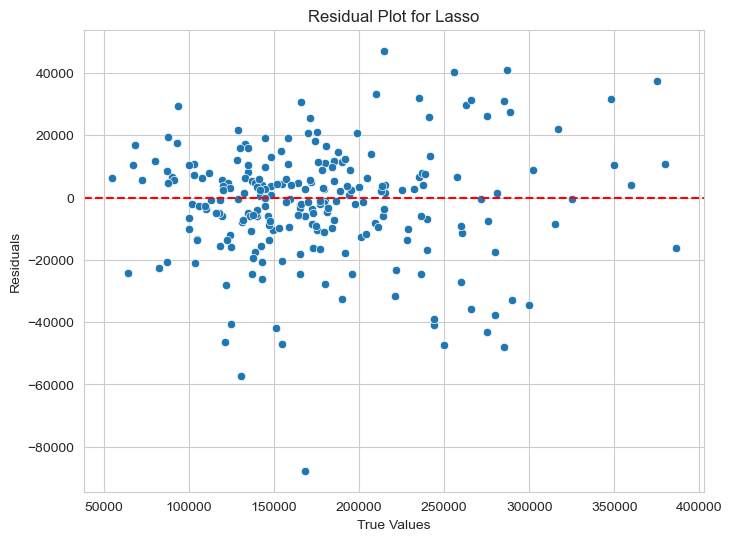

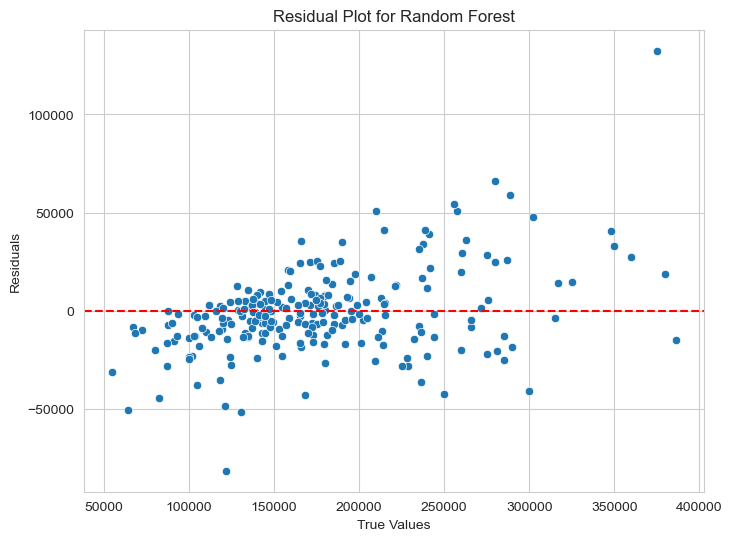

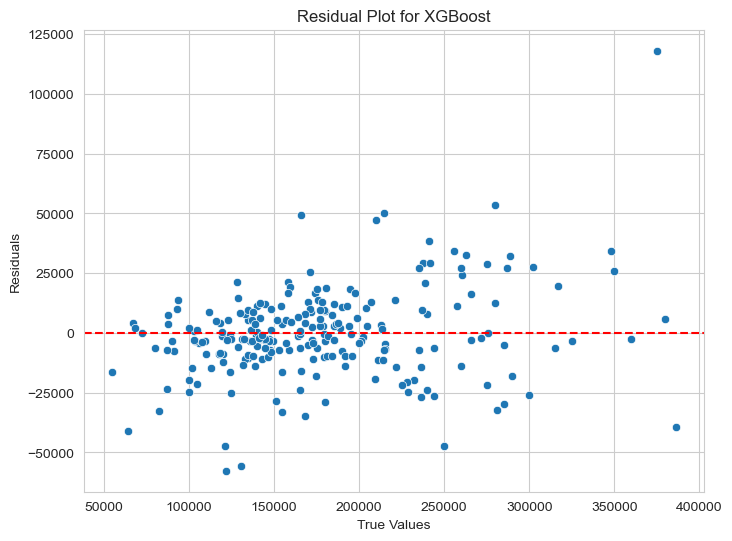

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {model_name}")
    plt.show()

# Plot residuals for each model on the testing set
for model_name, model in [("Lasso", final_lasso), ("Random Forest", final_RF_model), ("XGBoost", final_XGB_model)]:
    y_test_pred = model.predict(X_test_scaled)
    plot_residuals(y_test, y_test_pred, model_name)

### AIC and BIC Curves:

In [36]:
import numpy as np

def calculate_aic_bic(model, X, y, y_pred):
    n = len(y)
    mse = mean_squared_error(y, y_pred)
    # For simplicity, we'll approximate k as the number of features used in the model.
    # This is a rough approximation, especially for non-linear models.
    k = X.shape[1]
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)
    return aic, bic

# Calculate and print AIC and BIC for each model on the testing set
for model_name, model in [("Lasso", final_lasso), ("Random Forest", final_RF_model), ("XGBoost", final_XGB_model)]:
    y_test_pred = model.predict(X_test_scaled)
    aic, bic = calculate_aic_bic(model, X_test_scaled, y_test, y_test_pred)
    print(f"{model_name} - AIC: {aic:.4f}, BIC: {bic:.4f}")

Lasso - AIC: 5047.2038, BIC: 5891.6544
Random Forest - AIC: 5125.8711, BIC: 5970.3218
XGBoost - AIC: 5057.1607, BIC: 5901.6113
